In [1]:
%%capture
!apt-get install cmake
!apt-get install zlib1g-dev
!pip install gym[atari]
!pip install JSAnimation

In [1]:
import numpy as np
# import cPickle as pickle
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import gym

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.optimizers import adam
import keras.backend as K


%matplotlib inline

/root/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/root/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
env = gym.make('CartPole-v0')
STATES, ACTIONS = env.observation_space.shape[0], env.action_space.n
print([STATES, ACTIONS])

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[4, 2]


In [3]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))


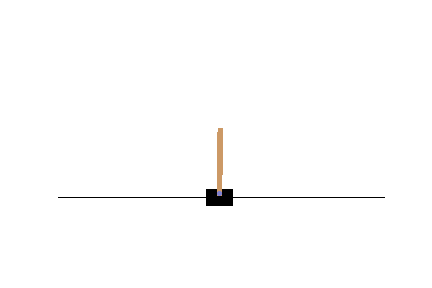
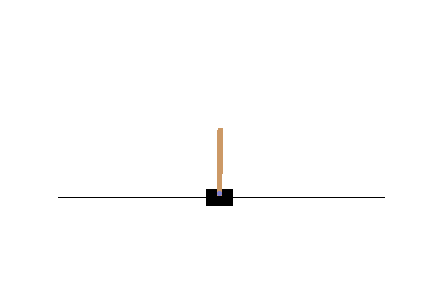
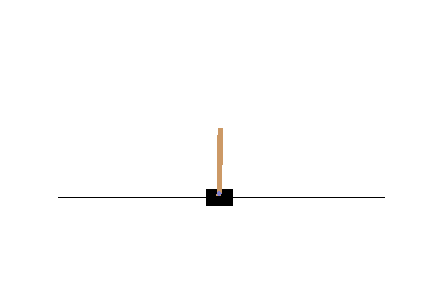
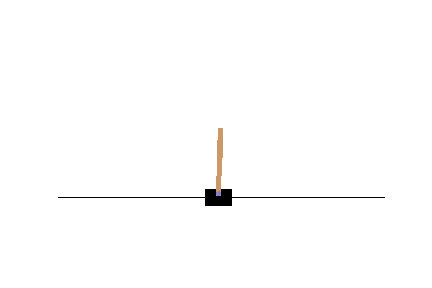
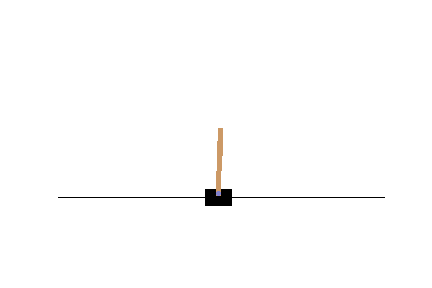
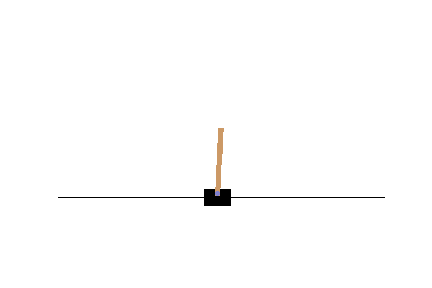
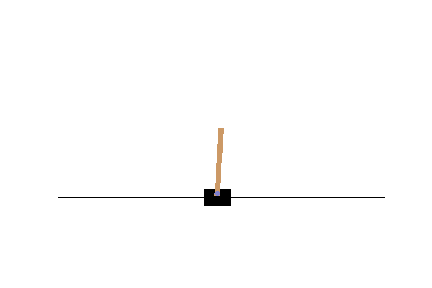
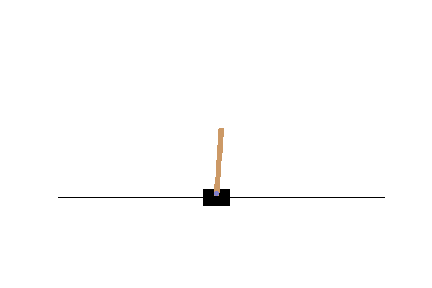
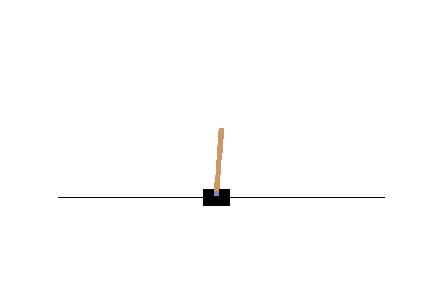
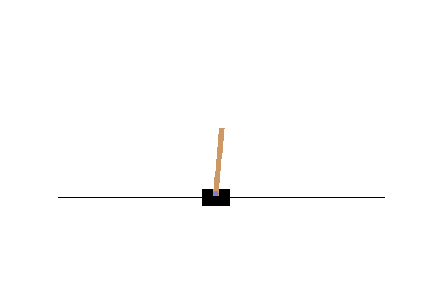
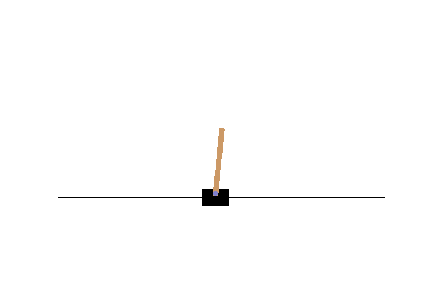
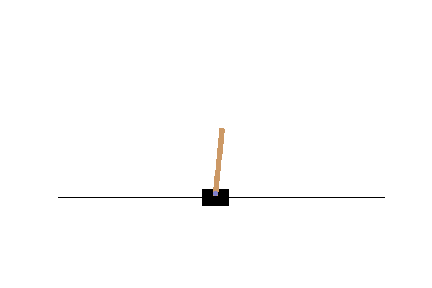
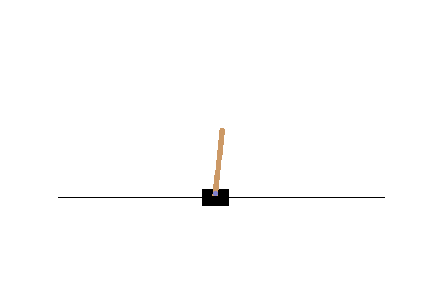
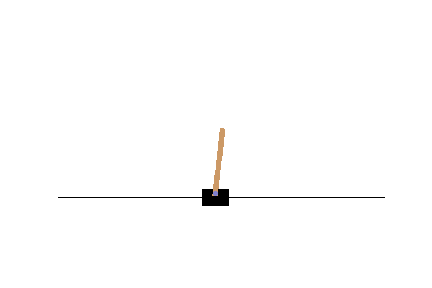
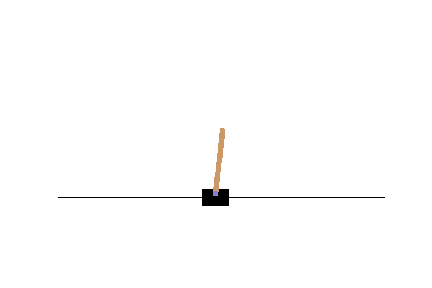
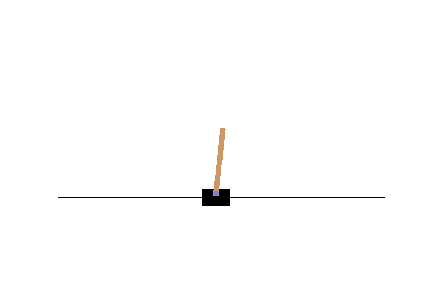
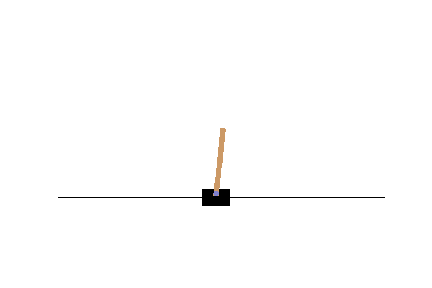
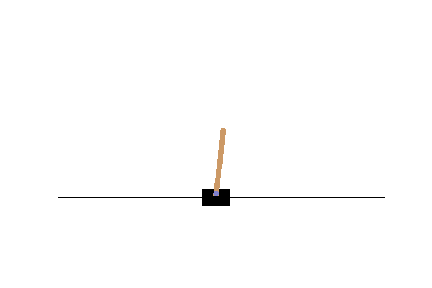
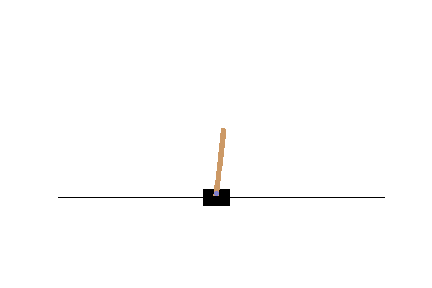
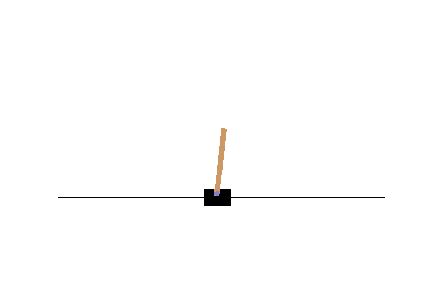
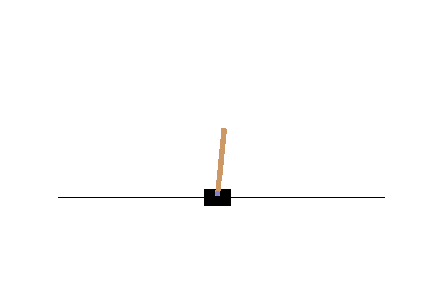
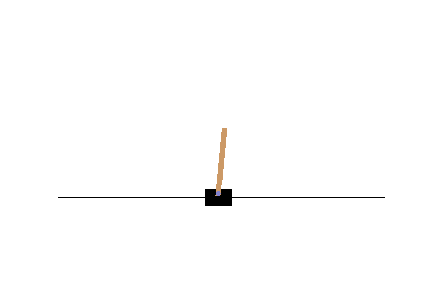
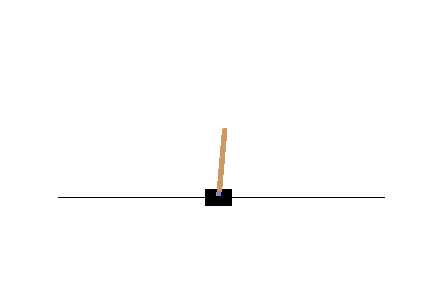
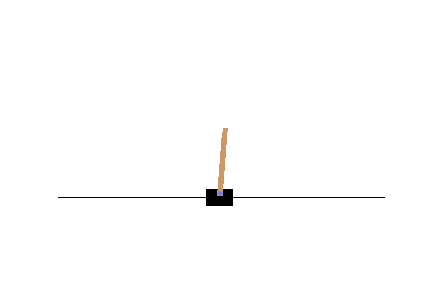
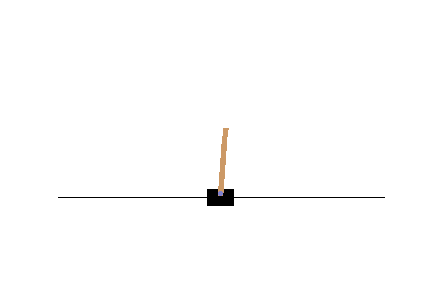
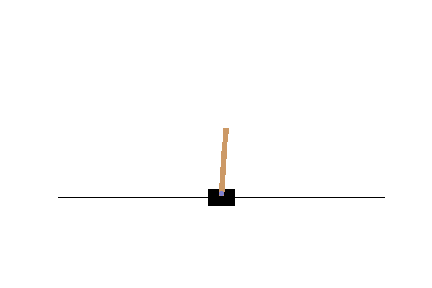
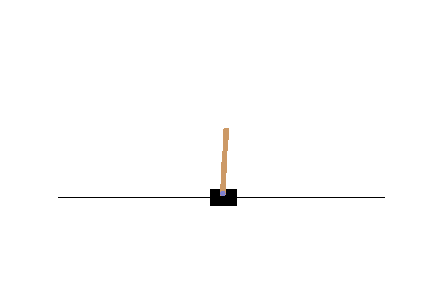
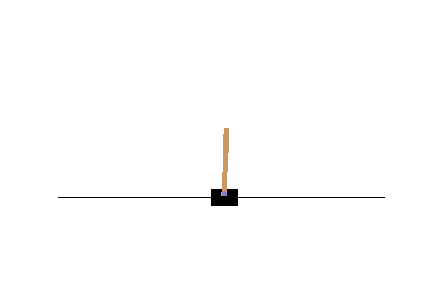
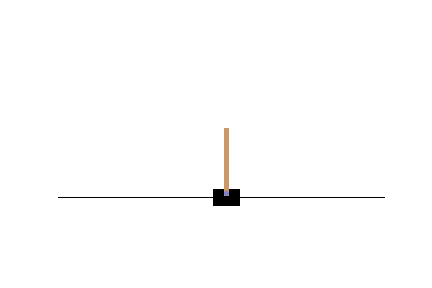
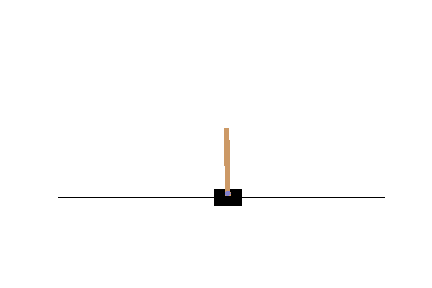
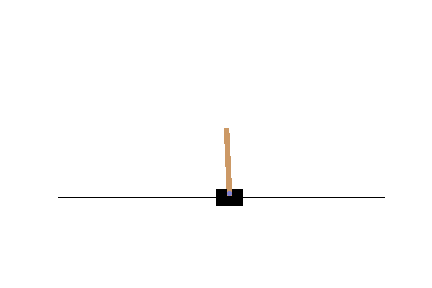
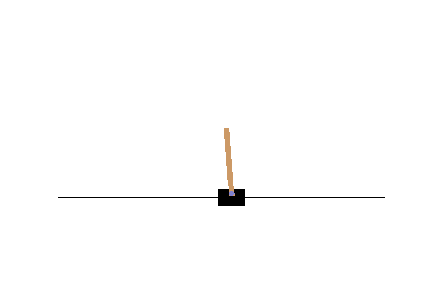
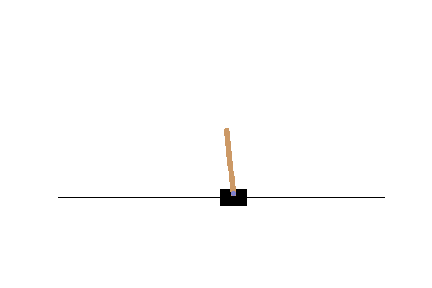
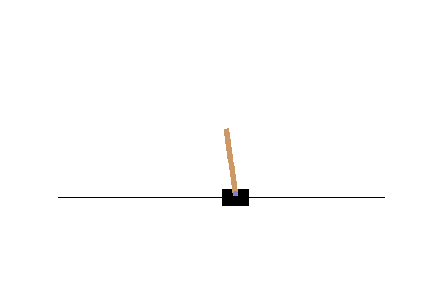
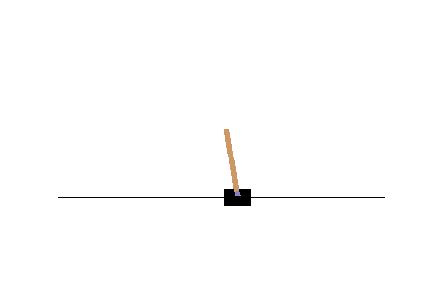
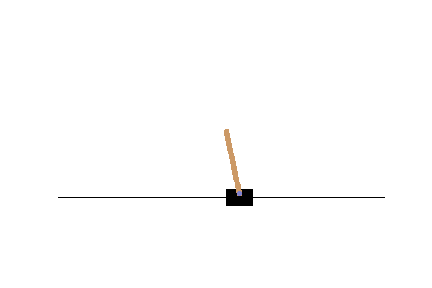

35


In [4]:
observation = env.reset()
cum_reward = 0
frames = []
r = []
for t in range(100):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    a = np.random.choice(ACTIONS)
    observation, reward, done, info = env.step(a)
    r.append(reward)
    if done:
        break
        
r = np.array(r)
# env.render(close=True)
display_frames_as_gif(frames)
print(t)

In [5]:
gamma = 0.99
def discount_rewards(rewards):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(len(discounted_r))):
        running_add =  rewards[t] + running_add * gamma # belman equation
        discounted_r[t] = running_add
    return discounted_r

def discount_n_standardise(rewards):
    dr = discount_rewards(rewards)
    dr = (dr - dr.mean()) / dr.std()
    return dr

## Reinforcement Learning

It turns out that action 2 makes the racket go up and 3 makes the racket go down. It has 6 actions by default because it's an Atari game, and there were 6 buttons in the controller. See [here](https://ai.stackexchange.com/questions/2449/what-are-different-actions-in-action-space-of-environment-of-pong-v0-game-from) for source of this answer.

In [6]:
def policy_loss(adv_y_true, y_pred):
    reward = adv_y_true[:,0]
    y_true = adv_y_true[:,1:]
#     from IPython.core.debugger import Tracer; Tracer()()
    return K.sum(reward*
                  K.sparse_categorical_crossentropy(y_true, y_pred), 
                  axis=-1)

In [12]:
model = Sequential()
model.add(Dense(16, input_dim=STATES, activation='relu'))
model.add(Dense(16, input_dim=STATES, activation='relu'))
model.add(Dense(ACTIONS, activation='softmax'))
model.compile(optimizer=adam(), loss=policy_loss) #

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


In [13]:
episodes = 0
n_episodes = 1000
reward_sums = np.zeros(n_episodes)
losses = np.zeros(n_episodes)
time_taken = np.zeros(n_episodes)
reward_sum = 0
prev_x = None
im_shape = (80, 80, 1)

buffer = 500
xs = np.zeros((buffer, STATES))
ys = np.zeros((buffer,1))
rs = np.zeros((buffer,1))

k = 0

observation = env.reset()

while episodes<n_episodes:
    xs[k] = observation
    p = model.predict(observation[None,:])
#     from IPython.core.debugger import Tracer; Tracer()()
    a = np.random.choice(ACTIONS, p=p[0])
    ys[k] = a
    
    observation, reward, done, info = env.step(a)
    reward_sum += reward
    rs[k] = reward
    
    k += 1
    
    if done or k==buffer:
        k = np.where(rs[:k]!=0)[0][-1]
        reward_sums[episodes] = reward_sum
        reward_sum = 0
        
        
        ep_x = xs[:k]
        ep_y = ys[:k]
        ep_r = rs[:k]
        
        ep_r = discount_n_standardise(ep_r)
        model.fit(ep_x, np.hstack([ep_r, ep_y]), batch_size=512, epochs=1, verbose=0)
        
        time_taken[episodes] = k
        k = 0
        observation = env.reset()
        losses[episodes] = model.evaluate(ep_x, 
                                          np.hstack([ep_r, ep_y]), 
                                          batch_size=len(ep_x), 
                                          verbose=0)
        episodes += 1
        
        if episodes%(n_episodes//20) == 0:
            ave_reward = np.mean(reward_sums[max(0,episodes-20):episodes])
            ave_loss = np.mean(losses[max(0,episodes-20):episodes])
            ave_time = np.mean(time_taken[max(0,episodes-20):episodes])
            print('Episode: {0:d}, Average Loss: {1:.4f}, Average Reward: {2:.4f}, Average steps: {3:.4f}'
                  .format(episodes, ave_loss, ave_reward, ave_time))
            if ave_reward > 195:
                print('Solved!')
                break

Episode: 50, Average Loss: -0.2003, Average Reward: 26.5500, Average steps: 25.5500
Episode: 100, Average Loss: -0.5610, Average Reward: 30.9000, Average steps: 29.9000
Episode: 150, Average Loss: -0.9267, Average Reward: 52.5000, Average steps: 51.5000
Episode: 200, Average Loss: -2.5208, Average Reward: 81.7000, Average steps: 80.7000
Episode: 250, Average Loss: -2.2739, Average Reward: 118.3500, Average steps: 117.3500
Episode: 300, Average Loss: -2.6553, Average Reward: 143.0000, Average steps: 142.0000
Episode: 350, Average Loss: -2.1165, Average Reward: 181.1000, Average steps: 180.1000
Episode: 400, Average Loss: -1.5926, Average Reward: 188.1500, Average steps: 187.1500
Episode: 450, Average Loss: -3.3651, Average Reward: 188.9000, Average steps: 187.9000
Episode: 500, Average Loss: -0.9923, Average Reward: 187.0000, Average steps: 186.0000
Episode: 550, Average Loss: -1.0628, Average Reward: 192.2000, Average steps: 191.2000
Episode: 600, Average Loss: -2.5196, Average Reward:

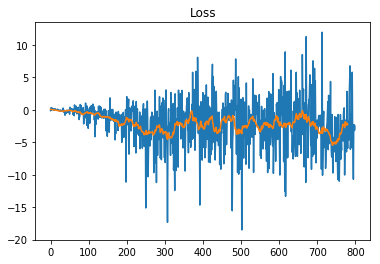

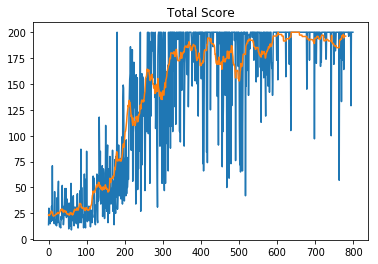

In [14]:
window = 20
plt.plot(losses[:episodes])
plt.plot(np.convolve(losses[:episodes], np.ones((window,))/window, mode='valid'))
plt.title('Loss')
plt.show()

plt.plot(reward_sums[:episodes])
plt.plot(np.convolve(reward_sums[:episodes], np.ones((window,))/window, mode='valid'))
plt.title('Total Score')
plt.show()

## Result


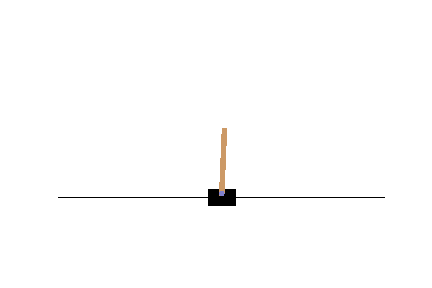
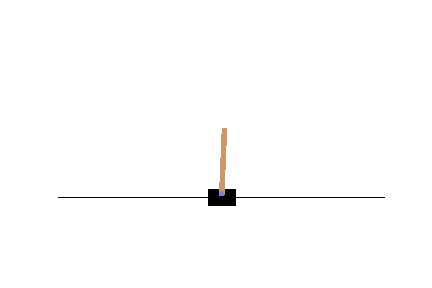
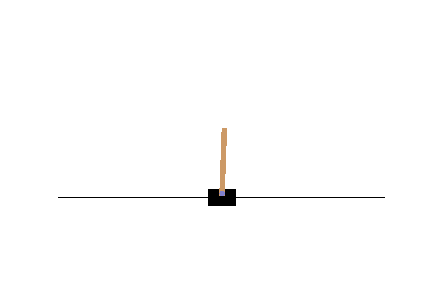
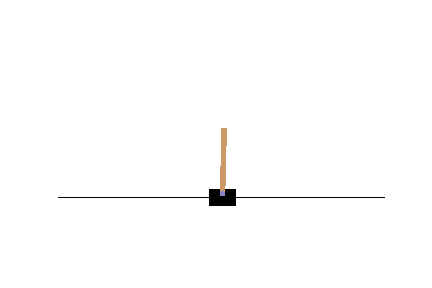
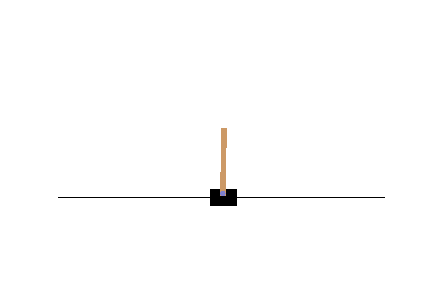
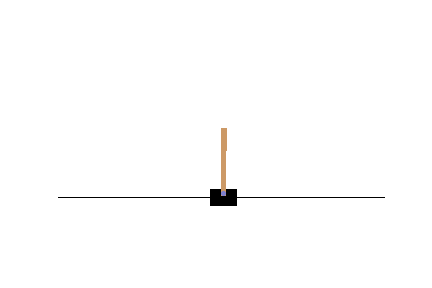
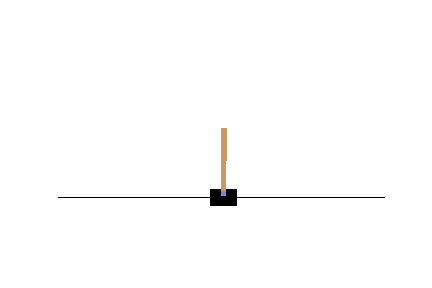
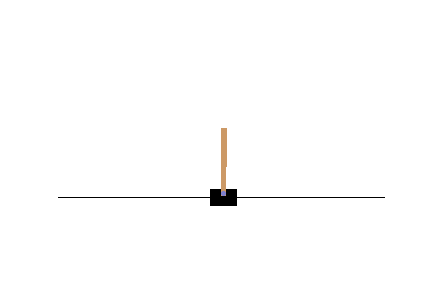
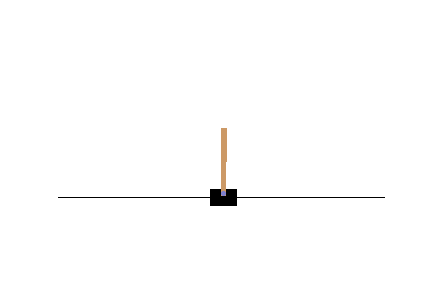
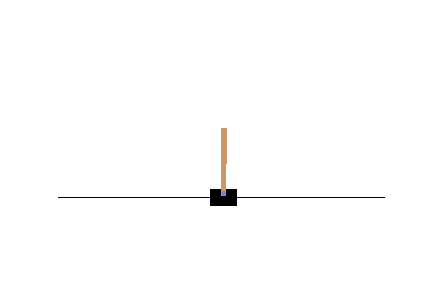
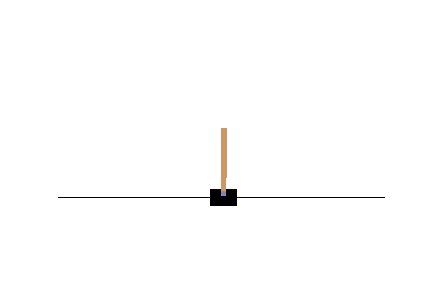
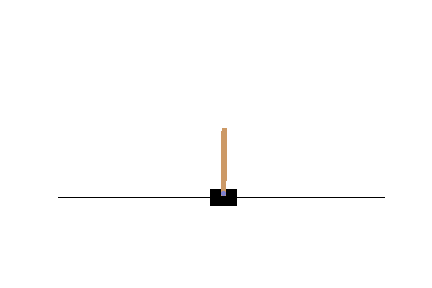
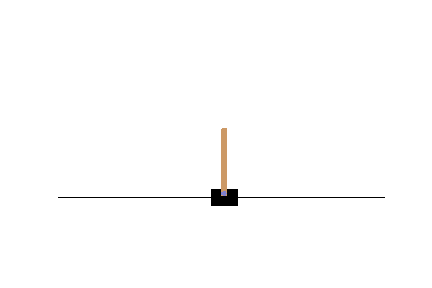
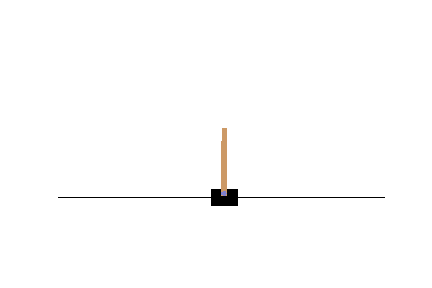
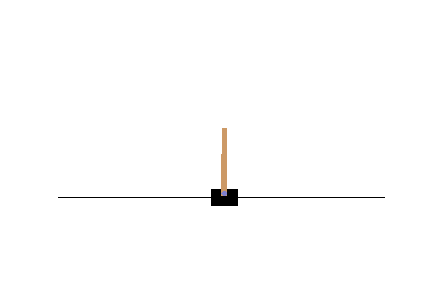
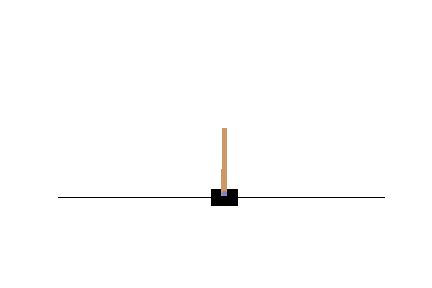
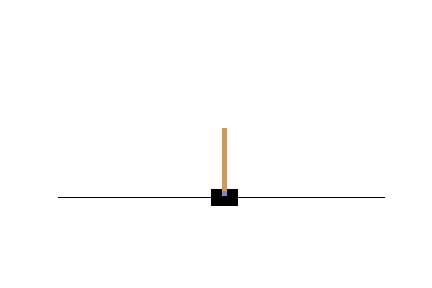
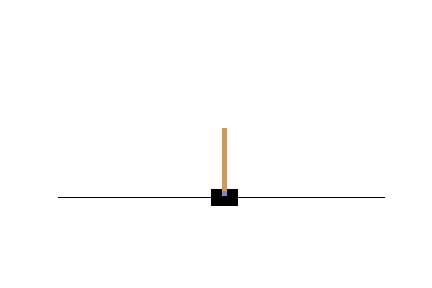
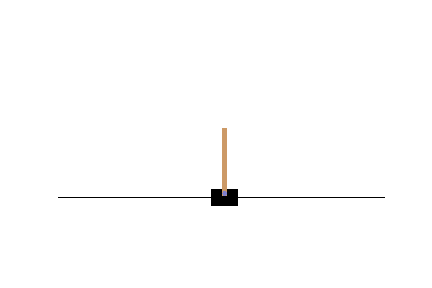
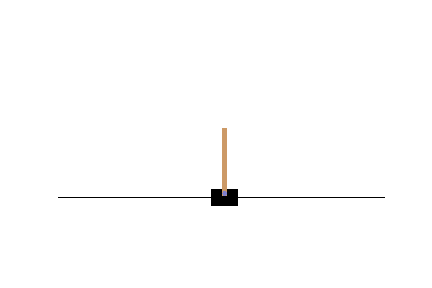
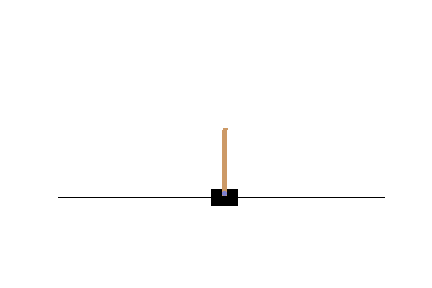
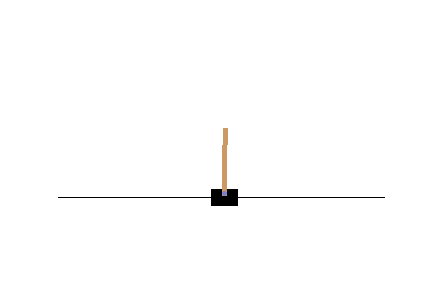
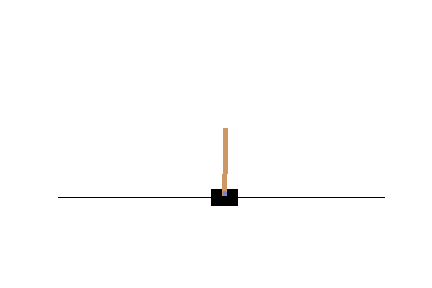
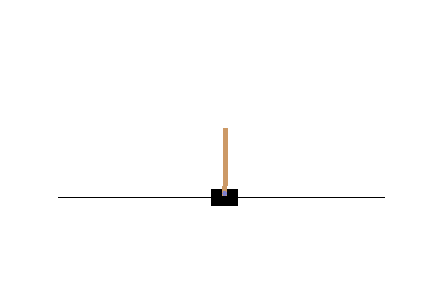
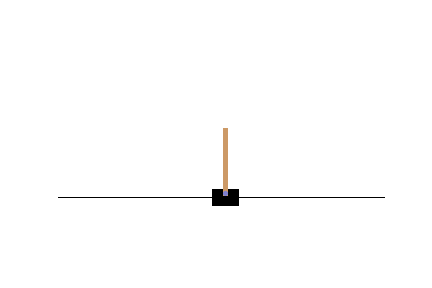
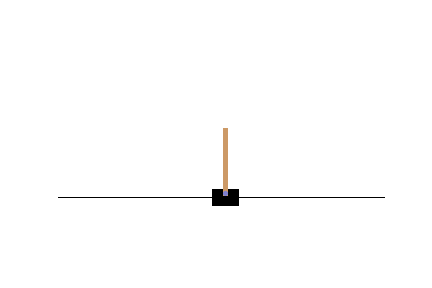
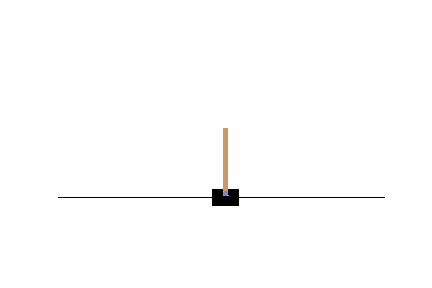
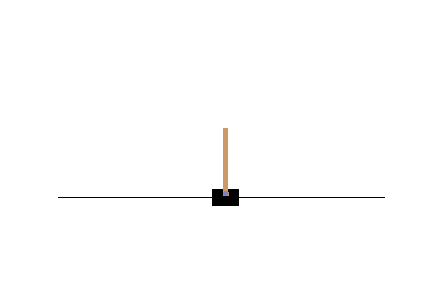
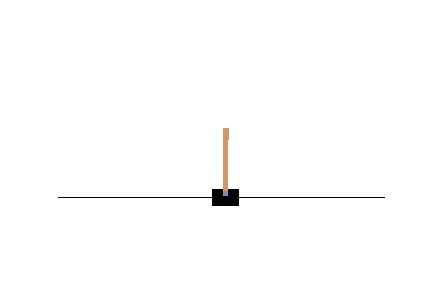
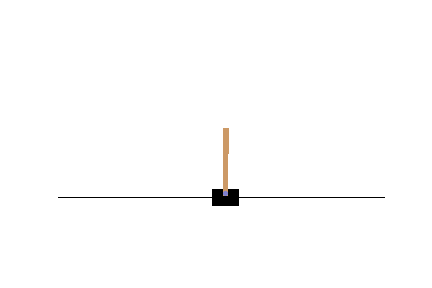
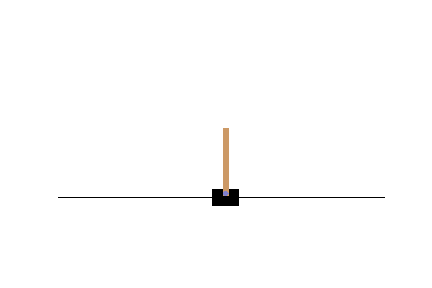
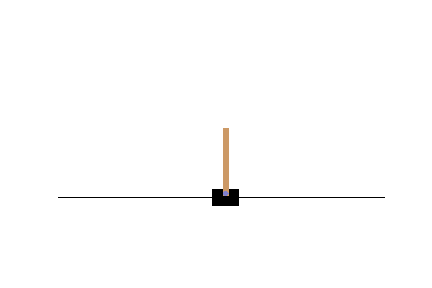
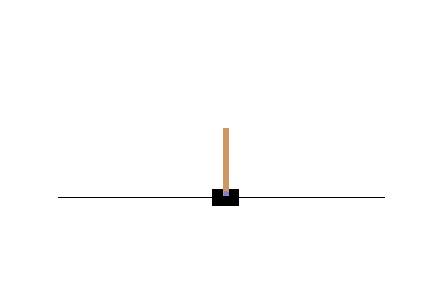
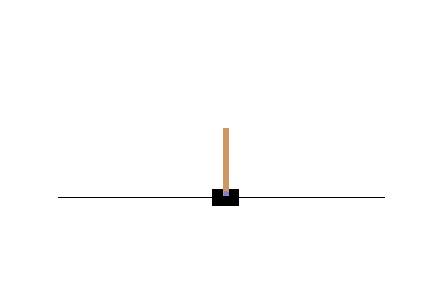
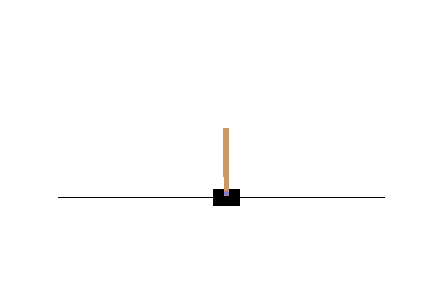
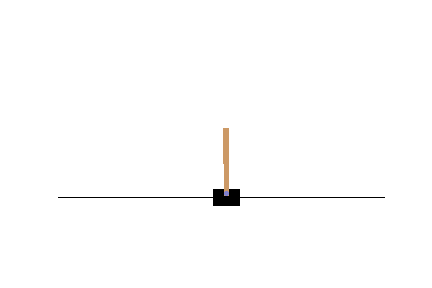
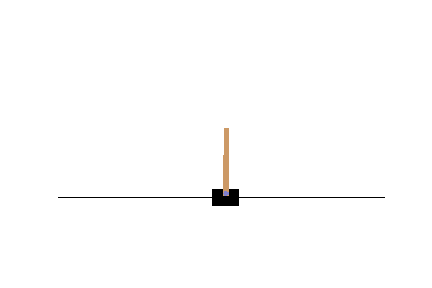
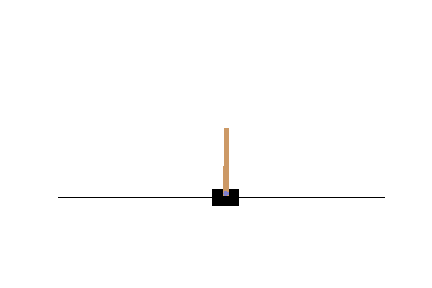
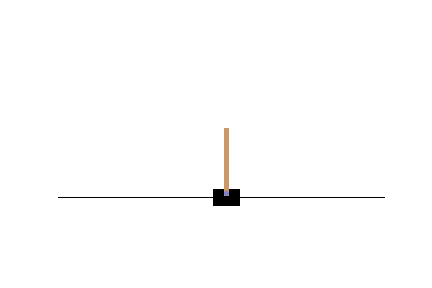
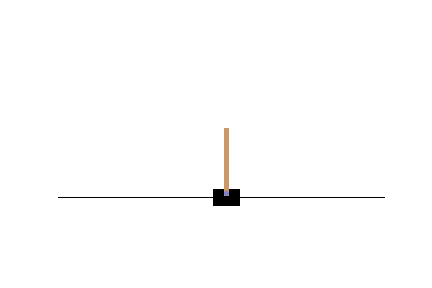
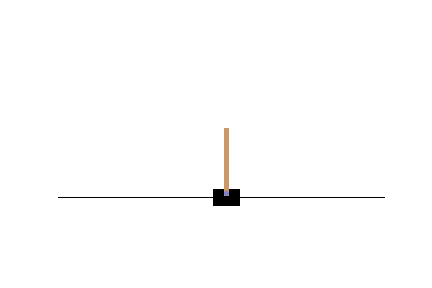
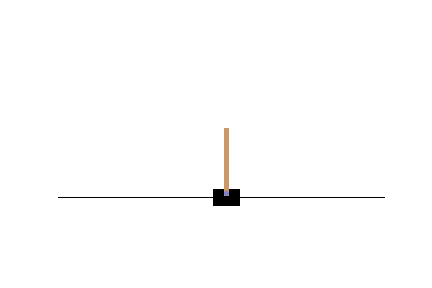
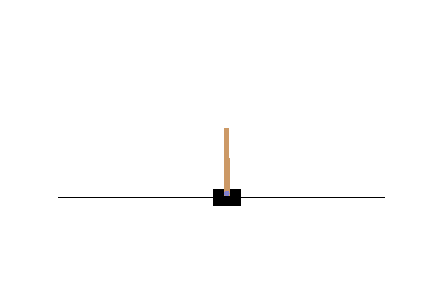
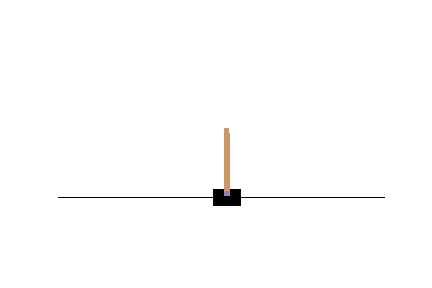
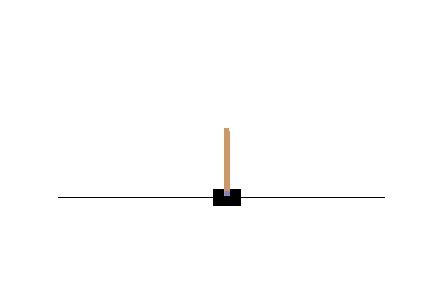
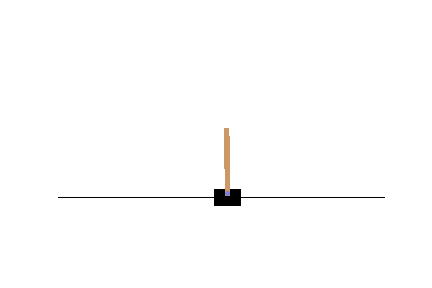
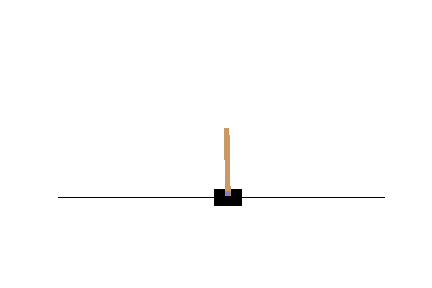
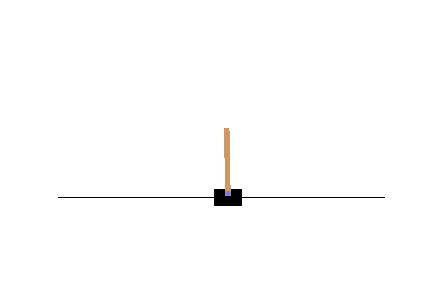
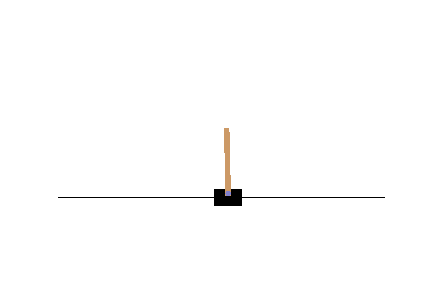
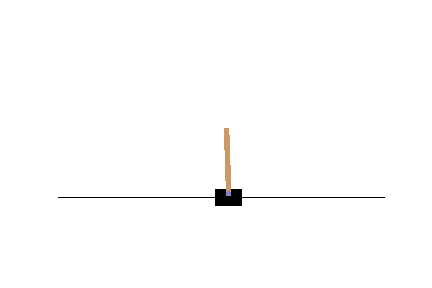
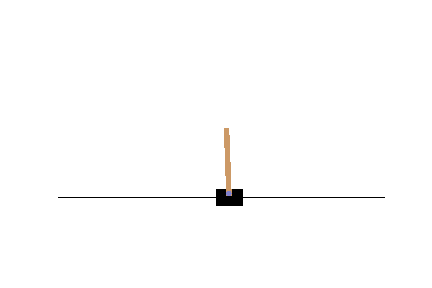
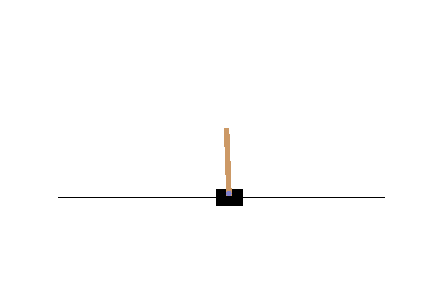
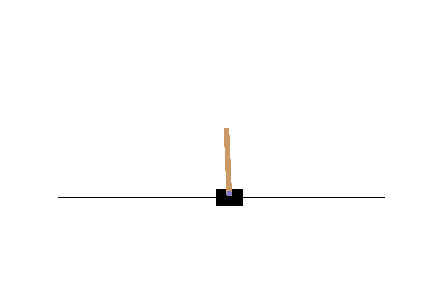
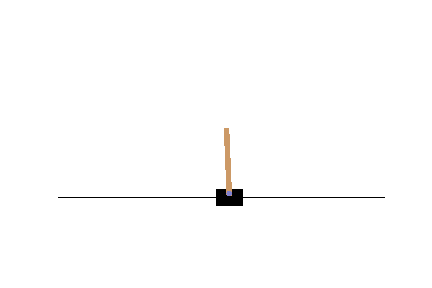
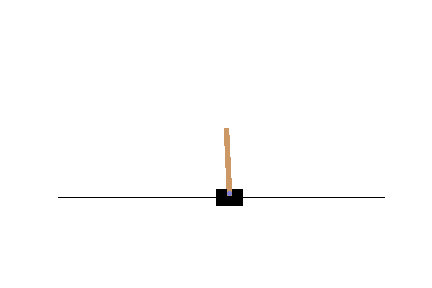
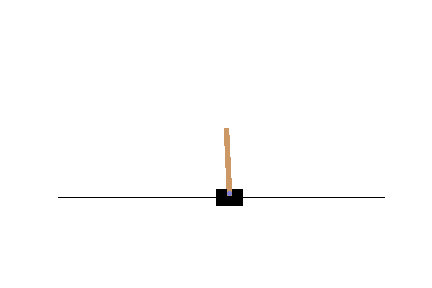
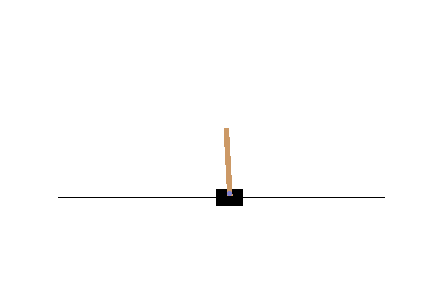
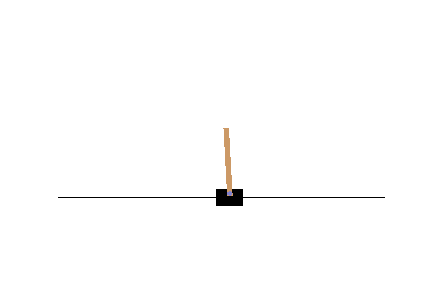
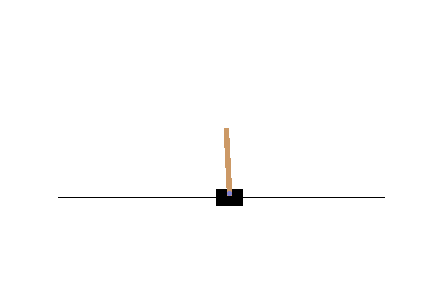
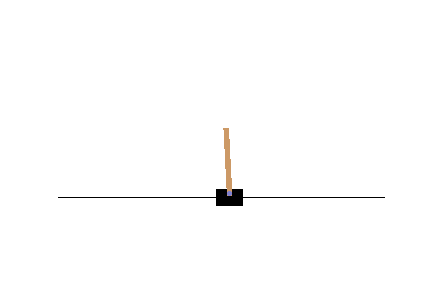
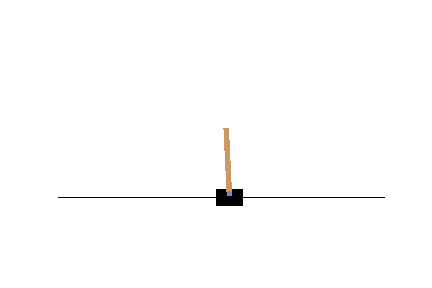
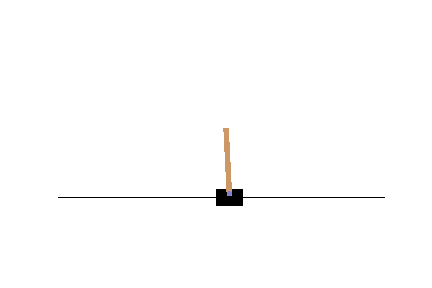
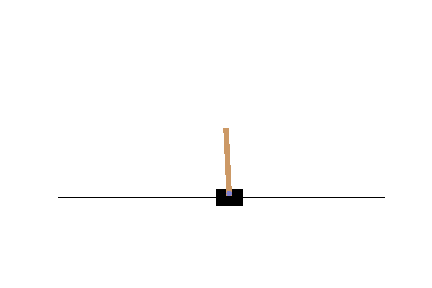
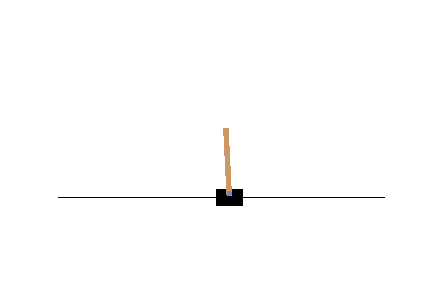
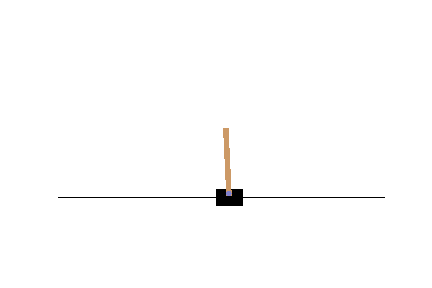
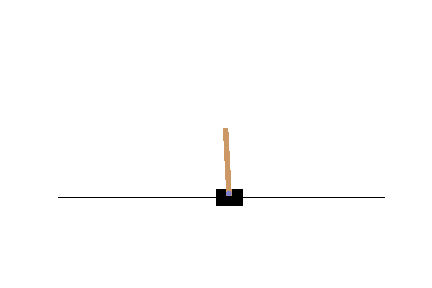
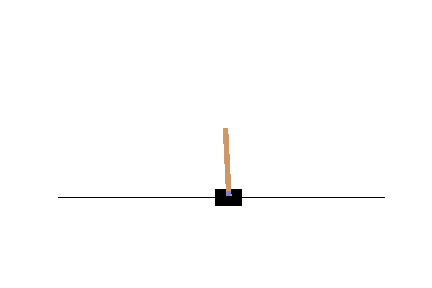
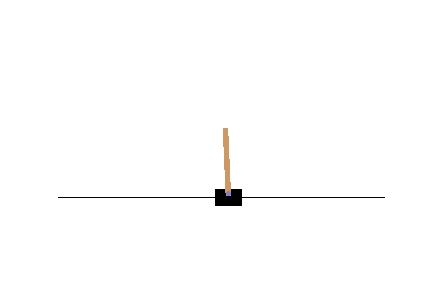
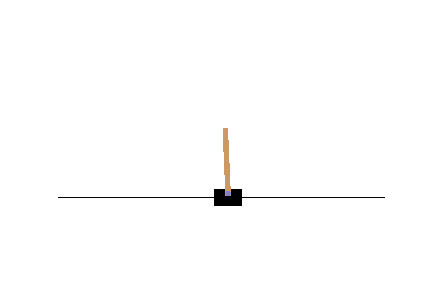
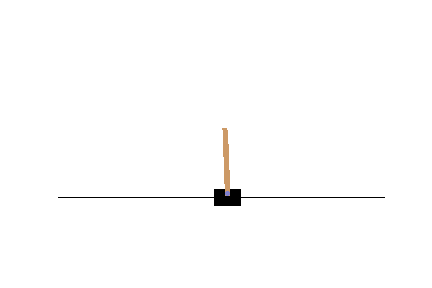
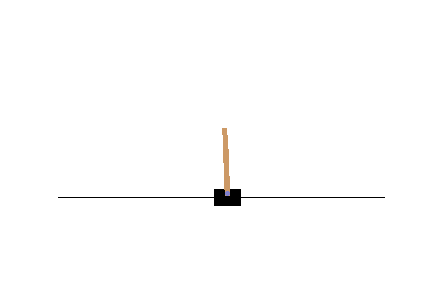
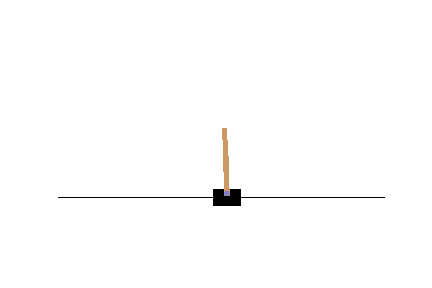
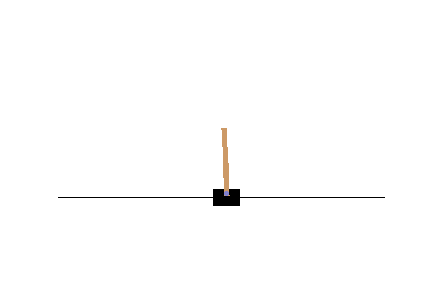
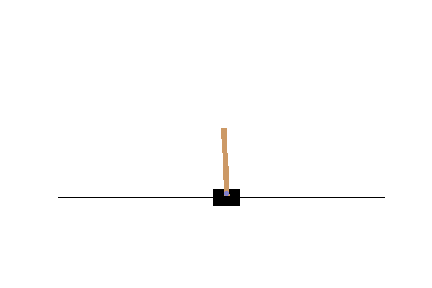
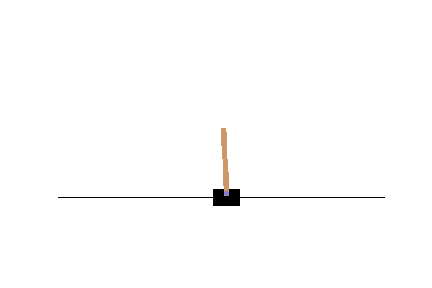
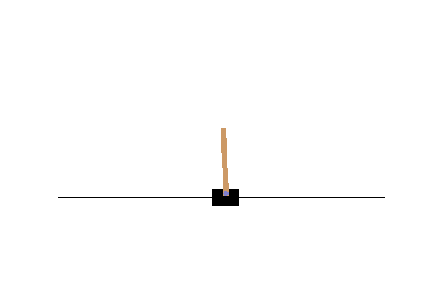
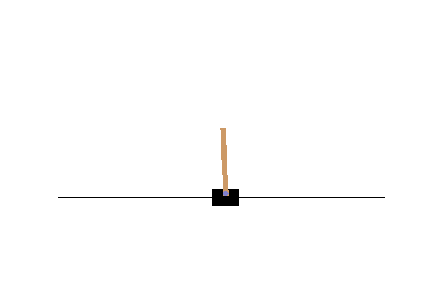
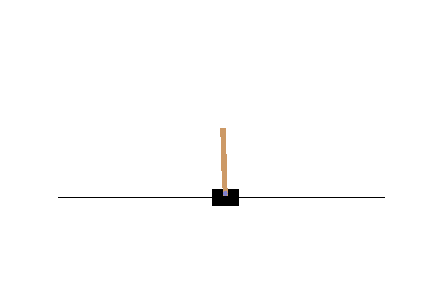
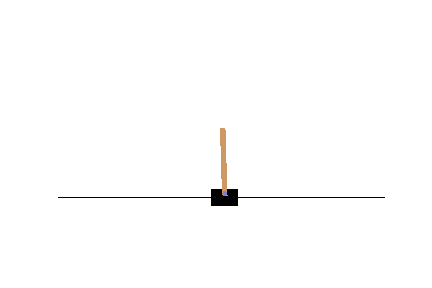
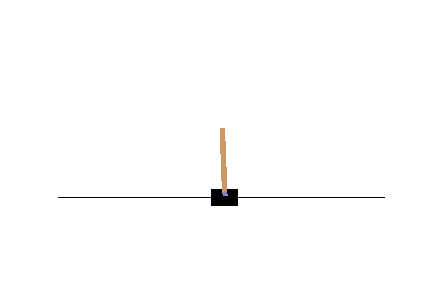
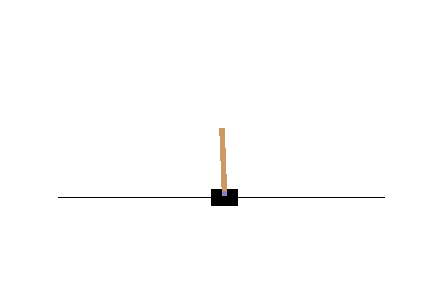
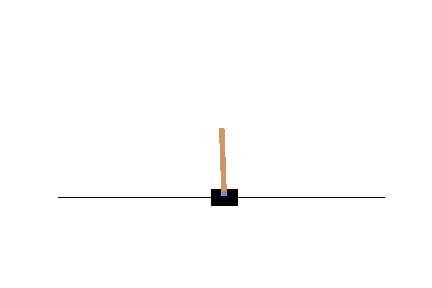
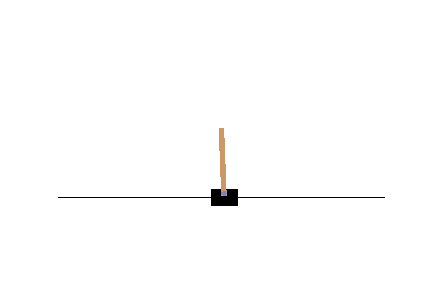
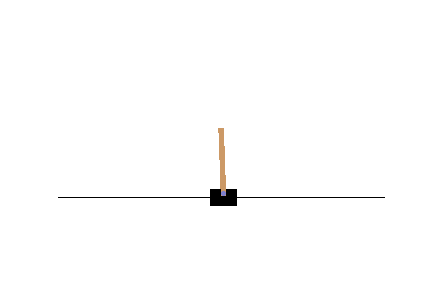
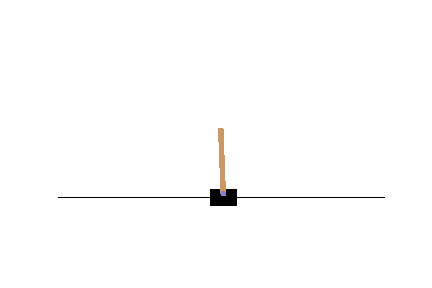
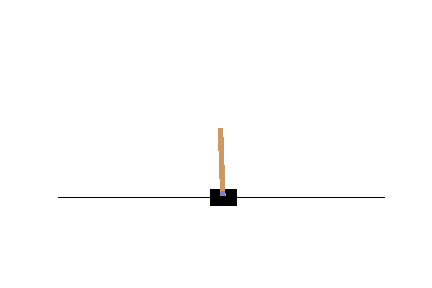
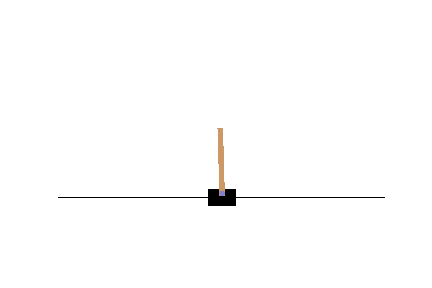
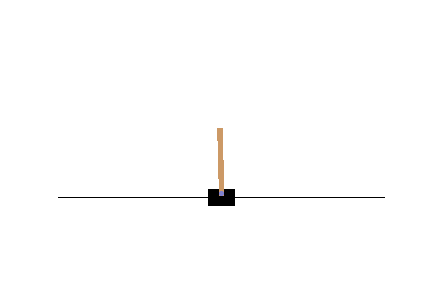
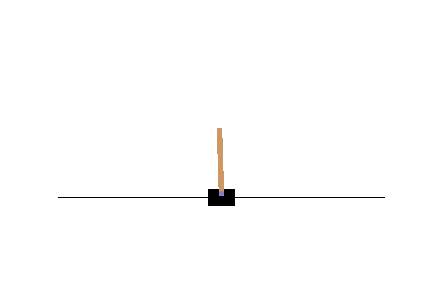
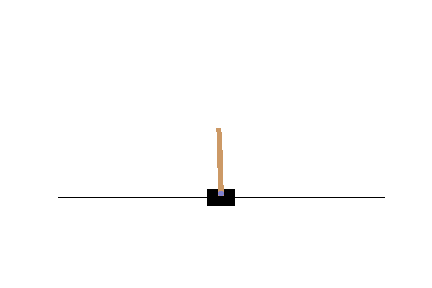
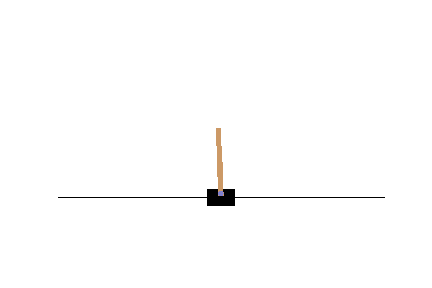
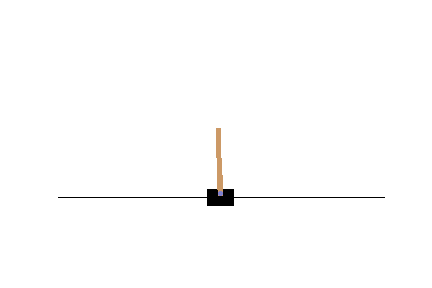
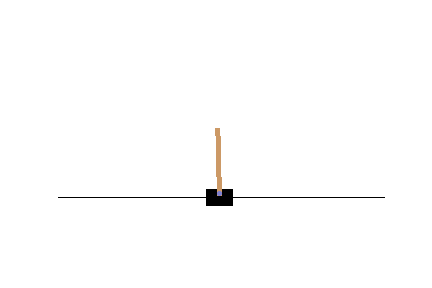
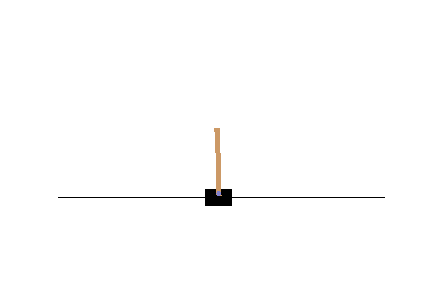
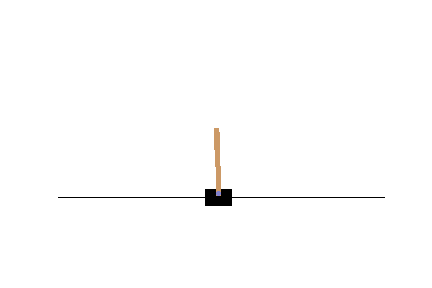
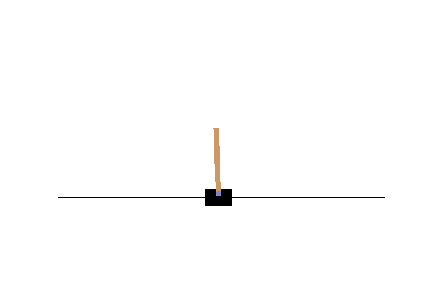
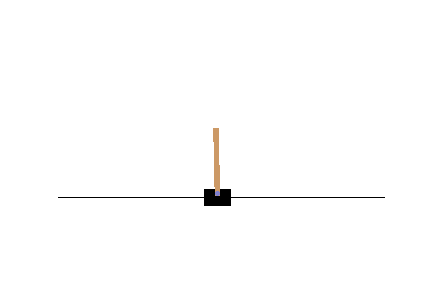
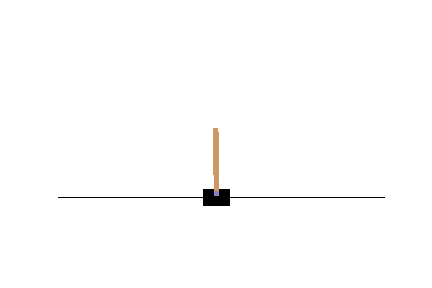
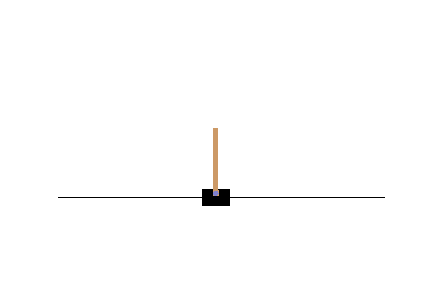
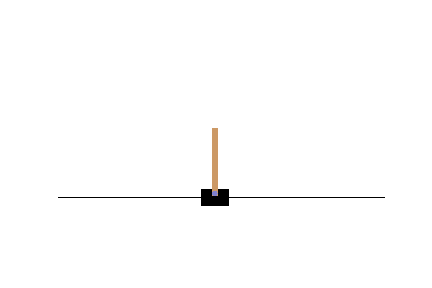

99


In [15]:
observation = env.reset()
cum_reward = 0
frames = []
r = []
for t in range(100):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    p = model.predict(observation[None,:])
    a = np.random.choice(ACTIONS,p=p.squeeze())
    observation, reward, done, info = env.step(a)
    r.append(reward)
    if done:
        break
        
r = np.array(r)
# env.render(close=True)
display_frames_as_gif(frames)
print(t)